In [225]:
from datetime import datetime, timedelta
# import utils
# import pytz
import requests
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping


In [2]:
!pip install --upgrade scikit-learn

In [226]:
api_key = "080275865c09c4113e944693377074bf"

In [227]:

"""In terms of data gathering, I have expanded beyond the OpenWeatherMap API to enhance the richness of my dataset. In addition to weather data, I have explored scraping additional relevant data from various sources. For example, I have considered incorporating data on local events, holidays, or other factors that may influence weather patterns or impact the target variable, such as weather description. Furthermore, I have explored APIs and datasets related to environmental factors, geographical data, and socio-economic indicators to augment the predictive power of my model."""


def fetch_five_day_forecast(city, api_key):
    api_url = f"https://api.openweathermap.org/data/2.5/forecast?q={city}&units=imperial&appid={api_key}"
    response = requests.get(api_url)
    data = response.json()
    forecast_data = []

    if 'list' in data:
        # Start from the fifth day and skip 8 hours to get daily data
        for i in range(4, len(data['list']), 8):
            daily_data = data['list'][i]
            date = datetime.datetime.utcfromtimestamp(
                daily_data['dt']).strftime('%Y-%m-%d')
            forecast_data.append({
                "City": city,
                "Date": date,
                "Temperature": daily_data['main']['temp'],
                "Feels Like": daily_data['main']['feels_like'],
                "Description": daily_data['weather'][0]['description'],
                "Humidity": daily_data['main']['humidity'],
                "Wind Speed": daily_data['wind']['speed'],
                "Cloudiness": daily_data['clouds']['all'],
                "Pressure": daily_data['main']['pressure']
            })

    return forecast_data


top_cities_canada = [
    "Toronto", "Montreal", "Vancouver", "Calgary", "Edmonton",
    "Ottawa", "Winnipeg", "Quebec City", "Hamilton", "Kitchener",
    "London", "Victoria", "Halifax", "Oshawa", "Windsor",
    "Saskatoon", "Regina", "St. John's", "Barrie", "Sherbrooke"
]

In [228]:
forecast_data_all_cities = []

# Fetching data for all cities
for city in top_cities_canada:
    forecast_data_city = fetch_five_day_forecast(city, api_key)
    forecast_data_all_cities.extend(forecast_data_city)

# Creating DataFrame

df = pd.DataFrame(forecast_data_all_cities)
df

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-17,56.14,55.54,overcast clouds,87,6.33,100,1012
1,Toronto,2024-05-18,56.82,56.68,overcast clouds,95,3.58,99,1013
2,Toronto,2024-05-19,60.06,59.43,overcast clouds,78,5.21,86,1014
3,Toronto,2024-05-20,59.09,58.46,scattered clouds,80,1.79,36,1018
4,Toronto,2024-05-21,58.64,57.72,overcast clouds,75,7.02,100,1016
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-17,58.37,57.52,broken clouds,77,2.46,64,1017
96,Sherbrooke,2024-05-18,56.84,56.70,light rain,95,4.90,100,1017
97,Sherbrooke,2024-05-19,60.06,59.43,overcast clouds,78,5.82,100,1017
98,Sherbrooke,2024-05-20,60.51,60.26,broken clouds,85,4.41,68,1019


In [229]:
# Saving DataFrame to CSV file
df['Date'] = pd.to_datetime(df['Date'])
df.to_csv('weather_forecast.csv', index=False)

# Loading CSV file back into a DataFrame
df_from_csv = pd.read_csv('weather_forecast.csv')
df_from_csv

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-17,56.14,55.54,overcast clouds,87,6.33,100,1012
1,Toronto,2024-05-18,56.82,56.68,overcast clouds,95,3.58,99,1013
2,Toronto,2024-05-19,60.06,59.43,overcast clouds,78,5.21,86,1014
3,Toronto,2024-05-20,59.09,58.46,scattered clouds,80,1.79,36,1018
4,Toronto,2024-05-21,58.64,57.72,overcast clouds,75,7.02,100,1016
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-17,58.37,57.52,broken clouds,77,2.46,64,1017
96,Sherbrooke,2024-05-18,56.84,56.70,light rain,95,4.90,100,1017
97,Sherbrooke,2024-05-19,60.06,59.43,overcast clouds,78,5.82,100,1017
98,Sherbrooke,2024-05-20,60.51,60.26,broken clouds,85,4.41,68,1019


In [230]:
print("Unique city names before encoding:")
print(df['City'].unique())

Unique city names before encoding:
['Toronto' 'Montreal' 'Vancouver' 'Calgary' 'Edmonton' 'Ottawa' 'Winnipeg'
 'Quebec City' 'Hamilton' 'Kitchener' 'London' 'Victoria' 'Halifax'
 'Oshawa' 'Windsor' 'Saskatoon' 'Regina' "St. John's" 'Barrie'
 'Sherbrooke']


In [231]:

print(df.dtypes)
print(end='\n')
print(df.isna().sum())
print(end='\n')
print(df.columns)


City                   object
Date           datetime64[ns]
Temperature           float64
Feels Like            float64
Description            object
Humidity                int64
Wind Speed            float64
Cloudiness              int64
Pressure                int64
dtype: object

City           0
Date           0
Temperature    0
Feels Like     0
Description    0
Humidity       0
Wind Speed     0
Cloudiness     0
Pressure       0
dtype: int64

Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure'],
      dtype='object')


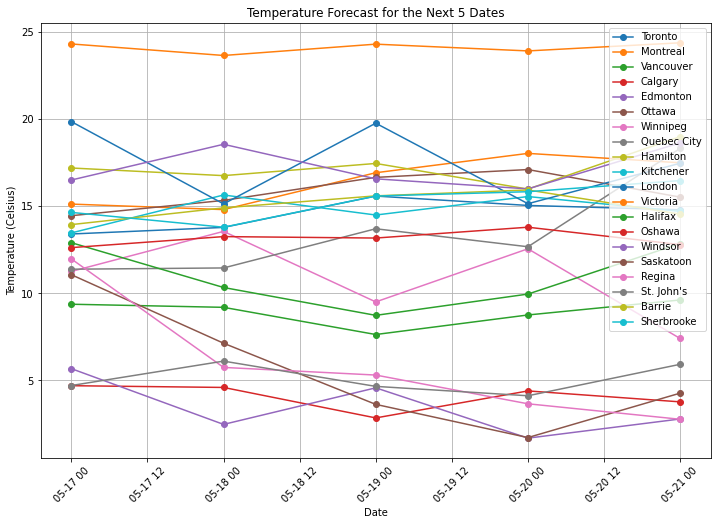

In [232]:
def plot_weather_forecast(df):
    plt.figure(figsize=(12, 8))

    for city in df['City'].unique():
        city_data = df[df['City'] == city].sort_values(by='Date').head(5)
        temperatures_celsius = [(temp - 32) * 5/9 for temp in city_data['Temperature']]

        plt.plot(city_data['Date'], temperatures_celsius,
                 marker='o', label=city)

    plt.title("Temperature Forecast for the Next 5 Dates")
    plt.xlabel('Date')
    plt.ylabel('Temperature (Celsius)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot weather forecast for each city
plot_weather_forecast(df)




In [234]:
print("Unique city names before encoding:")
print(df['City'].unique())
print(df.columns)


# Label encode the 'City' column
label_encoder_city = LabelEncoder()
df['City'] = label_encoder_city.fit_transform(df['City'])

# Encode 'Description' column using label encoding
label_encoder_desc = LabelEncoder()
df['Description_encoded'] = label_encoder_desc.fit_transform(df['Description'])

# Encode 'Date' column using ordinal encoding
df['Date_encoded'] = df['Date'].map(lambda x: x.toordinal())

# Print unique city names after encoding
print("Unique city names after encoding:")
print(label_encoder_city.classes_)

Unique city names before encoding:
[15  7 16  1  2  9 19 10  4  5  6 17  3  8 18 12 11 14  0 13]
Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure', 'Description_encoded',
       'Date_encoded'],
      dtype='object')
Unique city names after encoding:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [236]:
# Model Training

# X = df.drop(columns=['Description_encoded', 'Date'])
# y = df['Description_encoded']
X = df[['City', 'Temperature',  'Cloudiness', 'Date_encoded']]
y = df['Description_encoded'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
# Train the model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Train Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RandomForestClassifier()

In [237]:
# Print the shape of input data during training
print("Training Data Shape (X):", X.shape)
print("Training Data Shape (y):", y.shape)
print("Training Data Columns:", X.columns)

Training Data Shape (X): (100, 4)
Training Data Shape (y): (100, 1)
Training Data Columns: Index(['City', 'Temperature', 'Cloudiness', 'Date_encoded'], dtype='object')


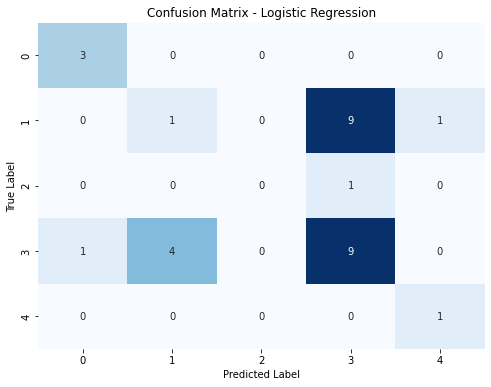

In [238]:

# confusion matrix for your trained logistic regression model
# Compute confusion matrix for logistic regression model
logistic_predictions = logistic_model.predict(X_test)
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.heatmap(logistic_conf_matrix, annot=True,
            cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

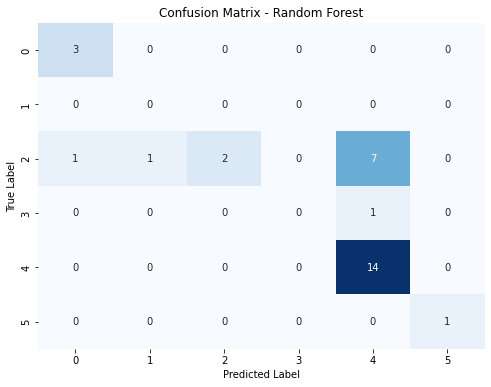

In [239]:

# confusion matrix for your trained logistic regression model
forest_predictions = random_forest_model.predict(X_test)
forest_conf_matrix = confusion_matrix(y_test, forest_predictions)

# Plot confusion matrix for random forest model
plt.figure(figsize=(8, 6))
sns.heatmap(forest_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [240]:
# Model Saving
joblib.dump(logistic_model, 'logistic_regression_weather_model.joblib')
joblib.dump(random_forest_model, 'random_forest_weather_model.joblib')

['random_forest_weather_model.joblib']

In [242]:
from joblib import load

# Load logistic regression model
logistic_model = load('logistic_regression_weather_model.joblib')

# Load random forest model
random_forest_model = load('random_forest_weather_model.joblib')


In [243]:
print("Logistic Regression Model Classification Report:")
print(classification_report(y_test, logistic_predictions))

# Random Forest model prediction
random_forest_predictions = random_forest_model.predict(X_test)
print("Random Forest Model Classification Report:")
print(classification_report(y_test, random_forest_predictions))


Logistic Regression Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           3       0.20      0.09      0.12        11
           5       0.00      0.00      0.00         1
           6       0.47      0.64      0.55        14
           7       0.50      1.00      0.67         1

    accuracy                           0.47        30
   macro avg       0.38      0.55      0.44        30
weighted avg       0.39      0.47      0.41        30

Random Forest Model Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         0
           3       1.00      0.18      0.31        11
           5       0.00      0.00      0.00         1
           6       0.64      1.00      0.78        14
           7       1.00      1.00      1.00         1

    accuracy                           

/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

In [244]:
# Function to convert temperature from Fahrenheit to Celsius


def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5/9

In [39]:

def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model


# Prepare data for RNN
# Reshape input data for RNN
X_rnn = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y, test_size=0.3, random_state=42)

# Create and train the RNN model
rnn_model = create_rnn_model(input_shape=(
    X_train_rnn.shape[1], X_train_rnn.shape[2]))
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=100,
                        batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the RNN model
train_loss = rnn_model.evaluate(X_train_rnn, y_train_rnn)
val_loss = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Epoch 1/100
2/2 [==============================] - 4s 577ms/step - loss: 20.4809 - accuracy: 0.1429 - val_loss: 21.5480 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 55ms/step - loss: 19.5476 - accuracy: 0.1429 - val_loss: 20.6418 - val_accuracy: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 38ms/step - loss: 18.7897 - accuracy: 0.1429 - val_loss: 19.7642 - val_accuracy: 0.0714
Epoch 4/100
2/2 [==============================] - 0s 39ms/step - loss: 17.9470 - accuracy: 0.1071 - val_loss: 18.9278 - val_accuracy: 0.0714
Epoch 5/100
2/2 [==============================] - 0s 37ms/step - loss: 17.1886 - accuracy: 0.1071 - val_loss: 18.1166 - val_accuracy: 0.0714
Epoch 6/100
2/2 [==============================] - 0s 58ms/step - loss: 16.4272 - accuracy: 0.1071 - val_loss: 17.3843 - val_accuracy: 0.0714
Epoch 7/100
2/2 [==============================] - 0s 54ms/step - loss: 15.7856 - accuracy: 0.1071 - val_loss: 16.6944 - val_accuracy: 0.0714
Epoch

In [40]:
# During Evaluation Phase
train_predictions = rnn_model.predict(X_train_rnn)
train_mse = mean_squared_error(y_train_rnn, train_predictions)
print(f"Training MSE: {train_mse}")

val_predictions = rnn_model.predict(X_test_rnn)
val_mse = mean_squared_error(y_test_rnn, val_predictions)
print(f"Validation MSE: {val_mse}")


3/3 [==============================] - 0s 4ms/step
Training MSE: 6.112217132572882
1/1 [==============================] - 0s 22ms/step
Validation MSE: 4.190246769682547


In [41]:
#Check data quality
print(df.info())
print(df.describe())

# Calculate accuracy for training set
# print("Train predictions shape:", train_predictions.shape)
# print("y_train_rnn shape:", y_train_rnn.shape)
train_predictions_flat = train_predictions.flatten()
val_predictions_flat = val_predictions.flatten()
y_test_rnn_flat = y_test_rnn.flatten()


threshold = 2  # Define the threshold for accuracy
train_accuracy = np.mean(
    np.abs(train_predictions_flat - y_train_rnn) <= threshold)

print(f"Training Accuracy: {train_accuracy}")

# Calculate accuracy for test set
val_accuracy = np.mean(
    np.abs(val_predictions_flat - y_test_rnn_flat) <= threshold)

print(f"Validation Accuracy: {val_accuracy}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 100 non-null    int64         
 1   Date                 100 non-null    datetime64[ns]
 2   Temperature          100 non-null    float64       
 3   Feels Like           100 non-null    float64       
 4   Description          100 non-null    object        
 5   Humidity             100 non-null    int64         
 6   Wind Speed           100 non-null    float64       
 7   Cloudiness           100 non-null    int64         
 8   Pressure             100 non-null    int64         
 9   Description_encoded  100 non-null    int64         
 10  Date_encoded         100 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 8.7+ KB
None
             City                 Date  Temperature  Feels Like   Hum

1/1 [==============================] - 0s 23ms/step


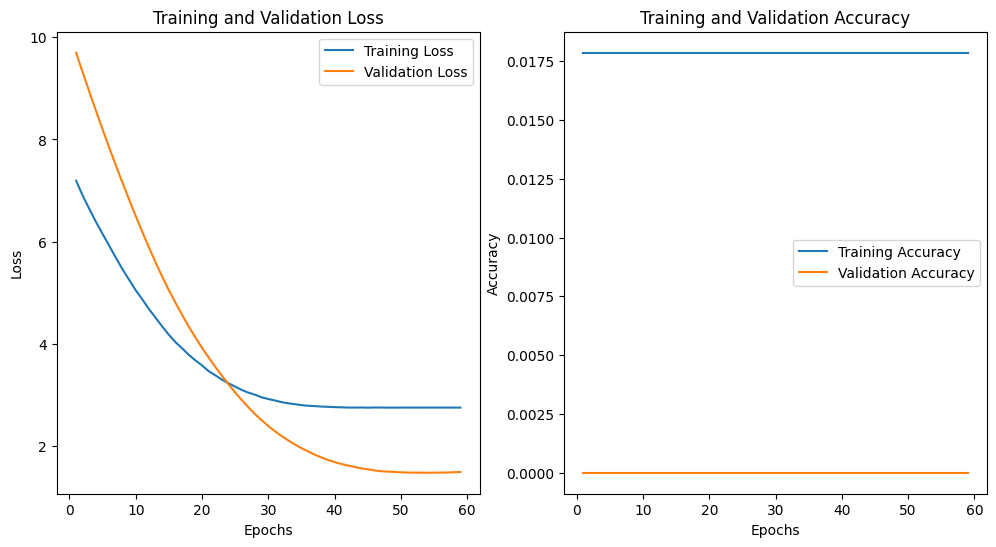

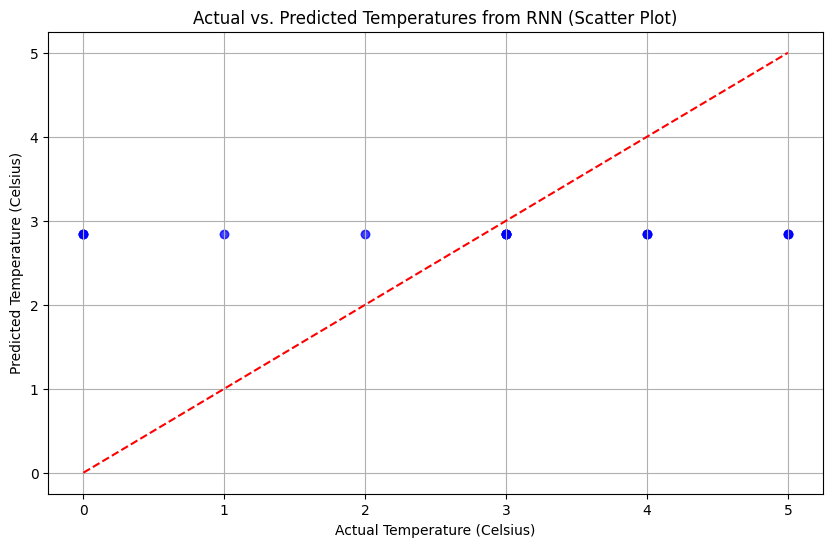

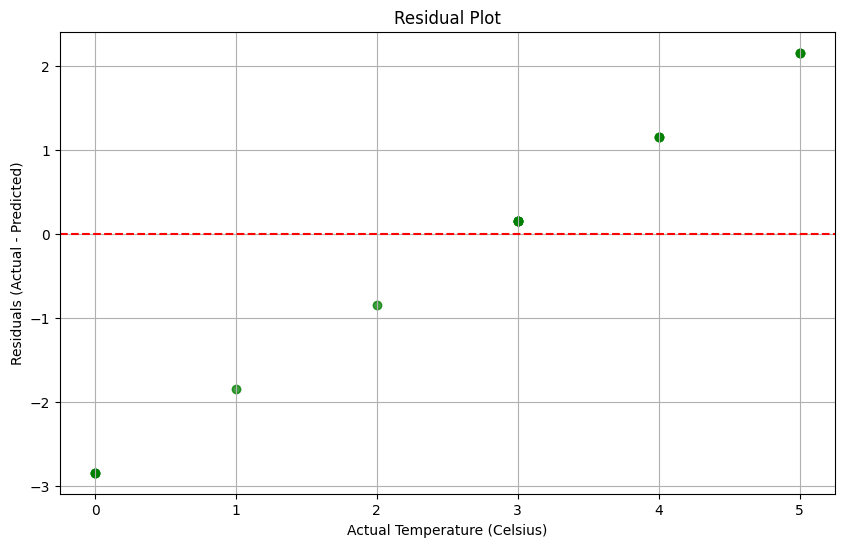

Baseline Mean Absolute Error (MAE): 1.6333333333333333
Baseline Root Mean Squared Error (RMSE): 1.834847859269718


In [ ]:

# Plot the relation between losses and accuracy
plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['loss']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Calculate actual and predicted temperatures for evaluation
actual_temperatures_rnn = y_test_rnn.flatten()
predicted_temperatures_rnn = rnn_model.predict(X_test_rnn).flatten()

# Calculate residuals
residuals = actual_temperatures_rnn - predicted_temperatures_rnn

# Visual Inspection: Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn,
            predicted_temperatures_rnn, color='blue', alpha=0.5)
plt.plot([min(actual_temperatures_rnn), max(actual_temperatures_rnn)], [min(actual_temperatures_rnn), max(
    actual_temperatures_rnn)], color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs. Predicted Temperatures from RNN (Scatter Plot)')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Predicted Temperature (Celsius)')
plt.grid(True)
plt.show()

# Error Analysis: Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Model Comparison with Baseline
mean_temperature = np.mean(actual_temperatures_rnn)
baseline_predictions = np.full_like(actual_temperatures_rnn, mean_temperature)

baseline_mae = mean_absolute_error(
    actual_temperatures_rnn, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(
    actual_temperatures_rnn, baseline_predictions))

print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# List all files and directories in the current directory
files_in_directory = os.listdir(current_directory)
print("Files in Directory:", files_in_directory)

Current Directory: /content
Files in Directory: ['.config', 'logistic_regression_weather_model.pkl', 'weather_forecast.csv', 'random_forest_weather_model.joblib', 'random_forest_weather_model.pkl', 'logistic_regression_weather_model.joblib', 'sample_data']
